# DCGAN - Deep Convolutional GANs

## Importação das bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
tf.__version__

'2.13.0'

## Carregamento e pré-processamento da base de dados

In [3]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
X_treinamento.shape

(60000, 28, 28)

In [5]:
28 * 28
# 784 pixels

784

In [6]:
y_treinamento.shape
# 60000 classes

(60000,)

5


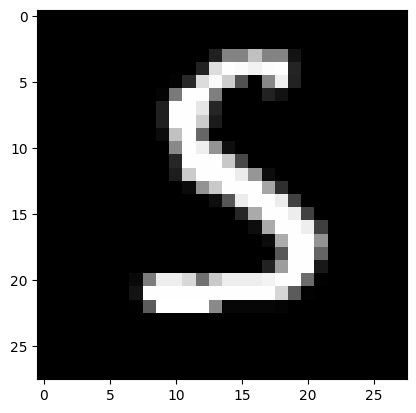

In [8]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray')

In [9]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')
# como trabalhamos em uma escala de cinza, temos apenas 1 canal de cor. Se fosse colorido seria 3 do RGB

In [10]:
X_treinamento.shape
# o numero 1 represehnta o canal

(60000, 28, 28, 1)

In [11]:
X_treinamento[0].min(), X_treinamento[0].max()
# 0 representa a cor preta e o 255 representa a cor branca
# quanto mais próximo de 0, mais escura é a imagem e quanto mais próximo de 255, mais clara

(0.0, 255.0)

In [12]:
X_treinamento = (X_treinamento - 127.5) / 127.5
# para trabalhar com GANs precisamos normalizar os dados
# neste caso pegamos o número 127.5 que é o meio entre 0 e 255

In [13]:
X_treinamento[0].min(), X_treinamento[0].max()
# dados normalizados entre -1 até 1

(-1.0, 1.0)

In [14]:
buffer_size = 60000 # quantidade de imagens
batch_size = 256 # quantidade do lote, vamos enviar para a rede neural de 256 em 256 imagens

In [15]:
buffer_size / batch_size
# 234.375 = Significa que vamos criar 234.375 lotes que conterá 256 imagens

234.375

In [16]:
type(X_treinamento)
# observamos que a base esta do tipo numpy array, porém precisamos converter para o tipo do tensorflow

numpy.ndarray

In [15]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)
# realizando a conversão
# shuffle mistura todos os dados

In [16]:
type(X_treinamento)
# visualizando o novo tipo

tensorflow.python.data.ops.batch_op._BatchDataset

In [17]:
X_treinamento

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
7*7*256

12544

In [19]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

In [20]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [21]:
# 100 -> 12544
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [22]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.31129107,  1.1638402 , -0.715858  ,  1.7189116 , -0.60354054,
         0.1331791 ,  0.37123662, -0.68985337,  0.38177264,  1.258702  ,
        -0.61802006, -1.786519  ,  1.0910977 ,  0.410783  , -0.18698978,
        -1.1025572 , -1.0642874 , -0.55676895,  1.2894295 , -1.2582567 ,
         1.1791016 , -0.87065417, -0.07322798, -1.417426  ,  0.42894387,
        -1.330564  , -1.0597    , -0.04447567, -0.18738672, -0.56451064,
        -0.40840554,  0.6198991 , -1.0695921 , -0.60735095, -0.98771304,
        -0.3368008 ,  0.15831883,  0.15766041,  2.0519404 , -1.5027182 ,
         1.7892789 ,  0.21648623,  1.4156237 ,  0.5515244 , -2.1703036 ,
        -1.2332951 ,  1.6452774 ,  0.34202808, -1.1448252 , -0.40614057,
         1.2039686 , -0.50490147, -0.2264265 ,  0.10479873, -0.64987296,
        -0.8035458 , -0.2533587 , -0.17716336,  0.02852184,  1.6357486 ,
        -0.70124364,  0.6048248 , -1.6987369 , -1.0651317 , -0.06374408,
 

In [23]:
imagem_gerada = gerador(ruido, training = False)

In [24]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

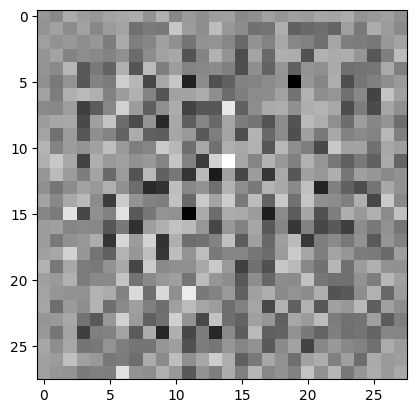

In [25]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

## Construção do discriminador

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [26]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [27]:
7 * 7 * 128

6272

In [28]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [29]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [30]:
discriminador(imagem_gerada, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00163113]], dtype=float32)>

In [31]:
tf.sigmoid(0.00356018)

<tf.Tensor: shape=(), dtype=float32, numpy=0.50089>

## Cálculo do erro

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações. Ele compara as previsões do discriminador em imagens reais com uma matriz de 1s e as previsões do discriminador em imagens falsas (geradas) com uma matriz de 0s.

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [33]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [34]:
tf.zeros_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [35]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [36]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [37]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Treinamento da GAN e visualização dos resultados

- Adaptado de: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.

In [38]:
X_treinamento

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [39]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [40]:
batch_size, dimensao_ruido

(256, 100)

In [41]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training = True)

    expected_output = discriminador(imagens, training = True)
    fake_output = discriminador(imagens_geradas, training = True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [42]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [43]:
60000 / 256

234.375

In [44]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch.shape)
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize = (10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

Época:  1


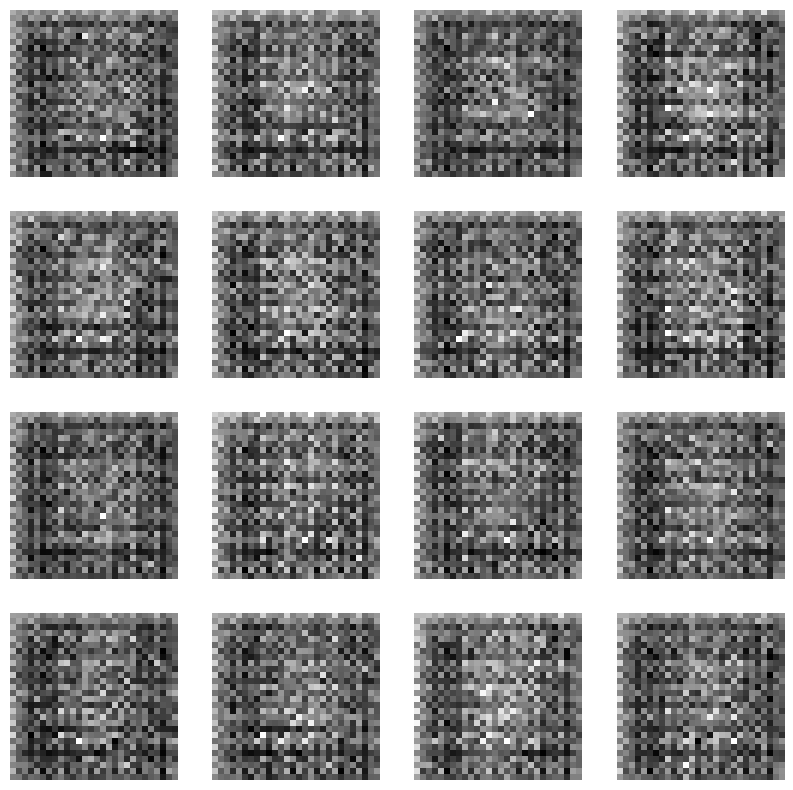

Época:  2


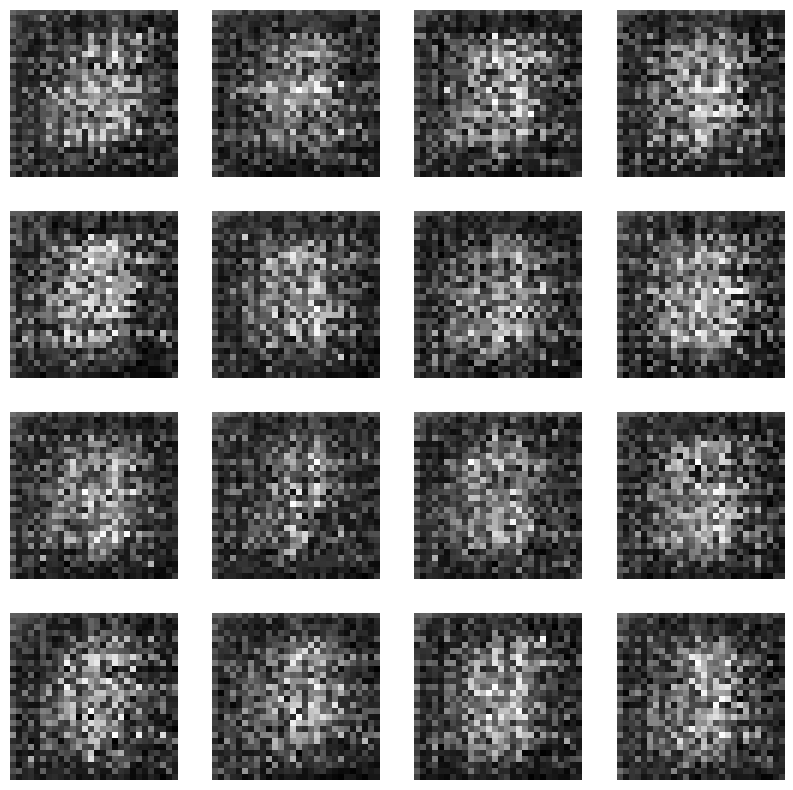

Época:  3


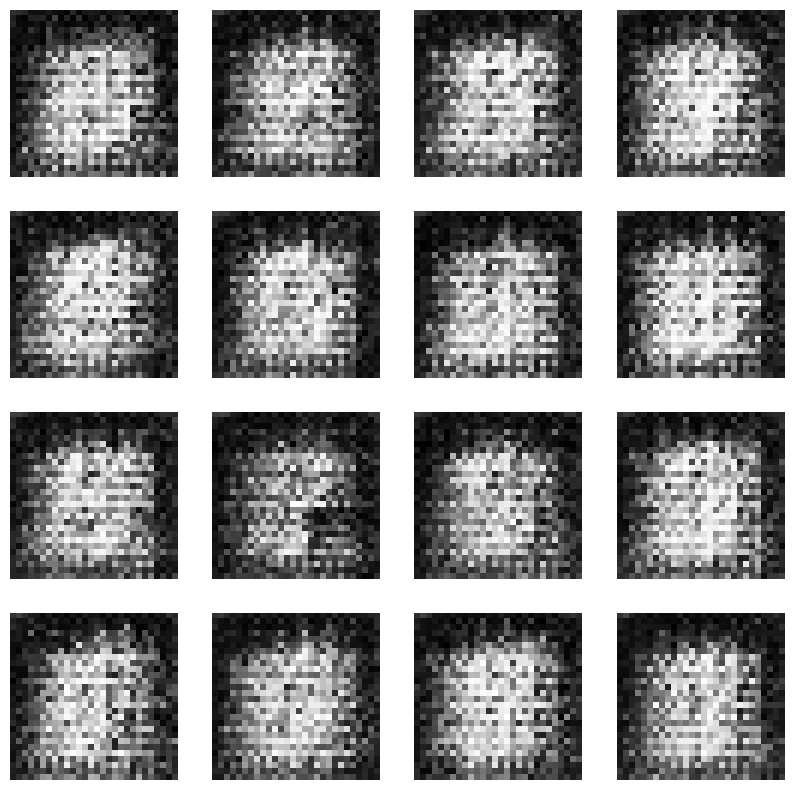

Época:  4


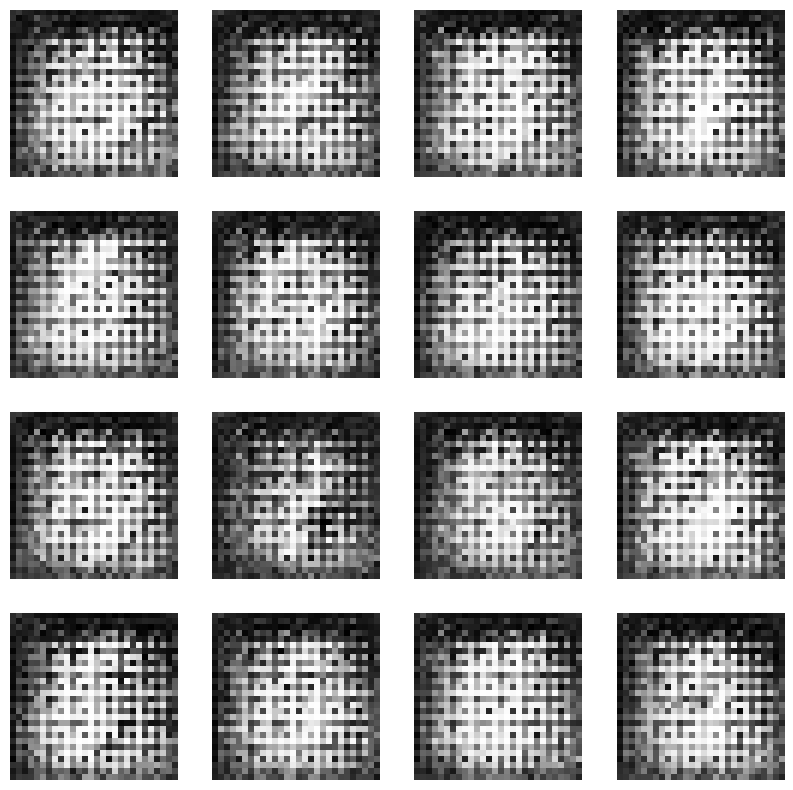

Época:  5


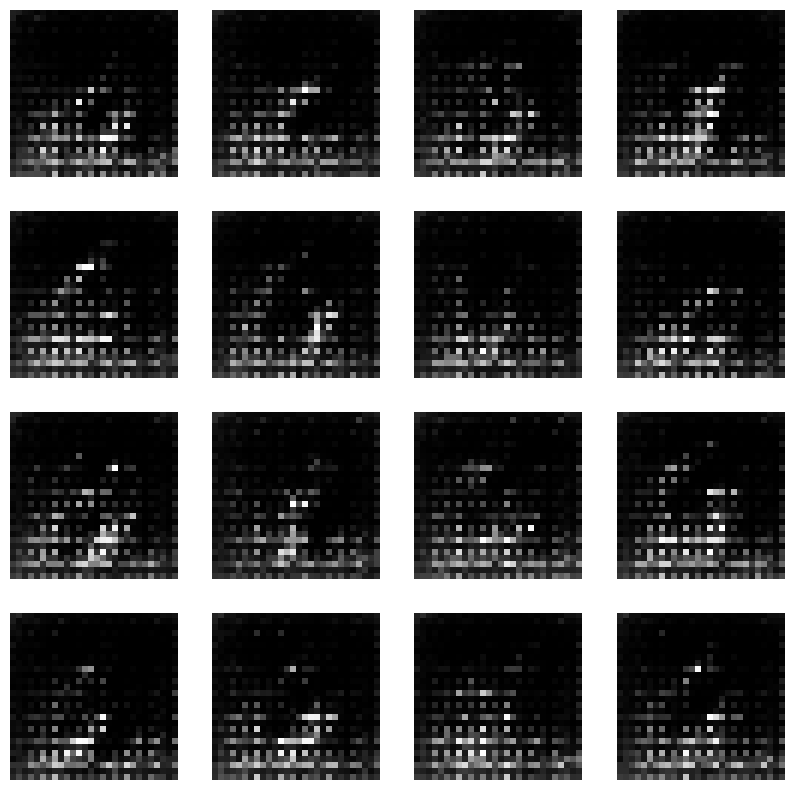

Época:  6


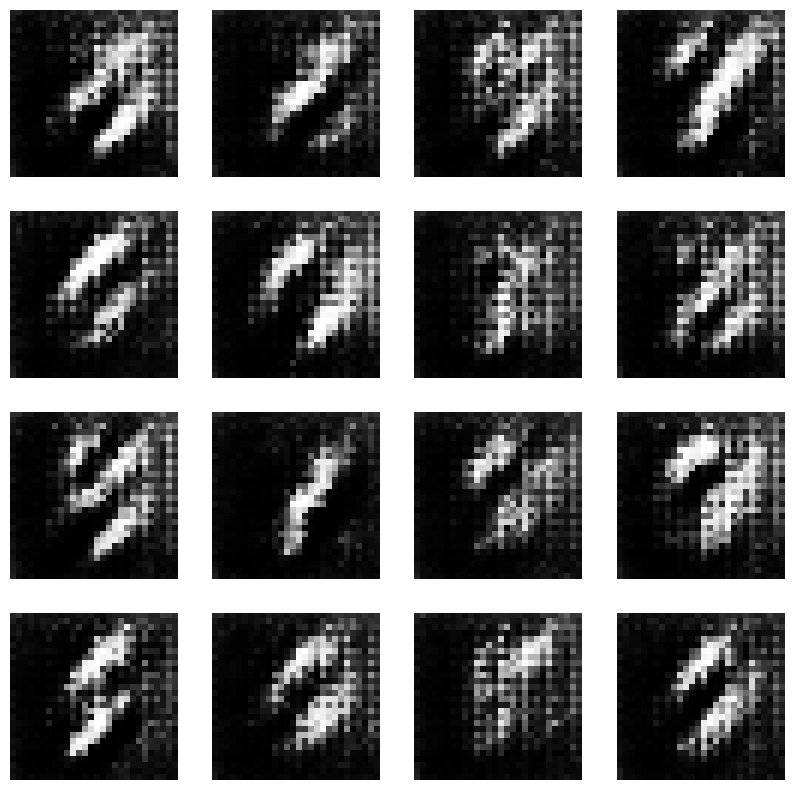

Época:  7


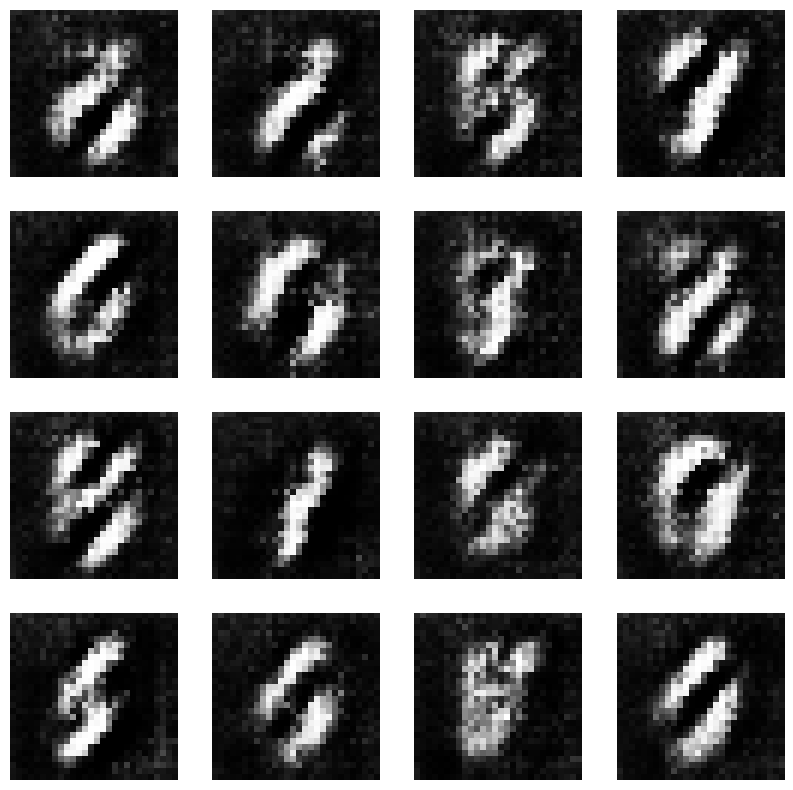

Época:  8


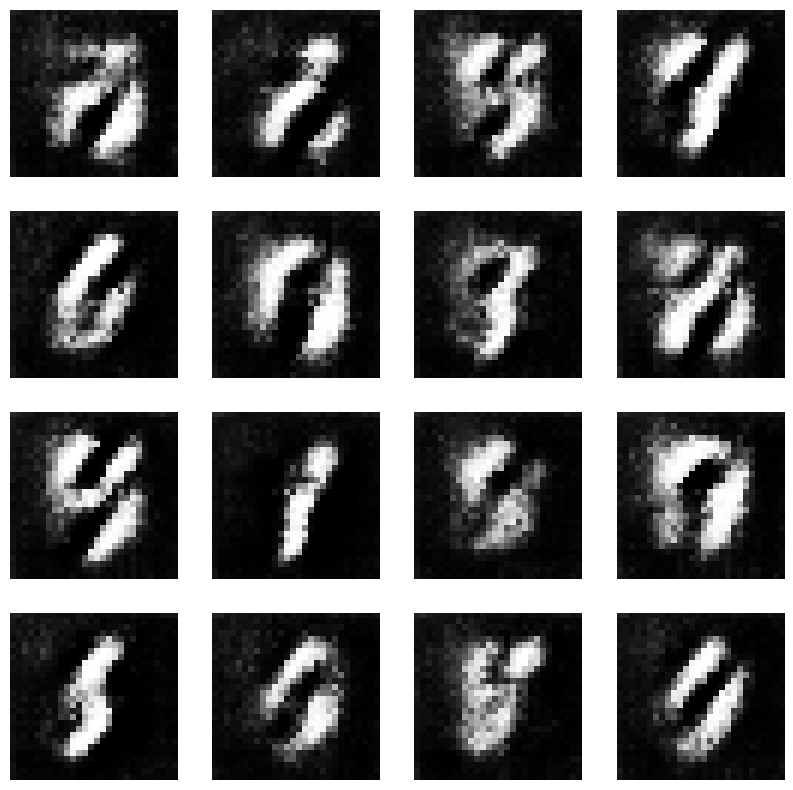

Época:  9


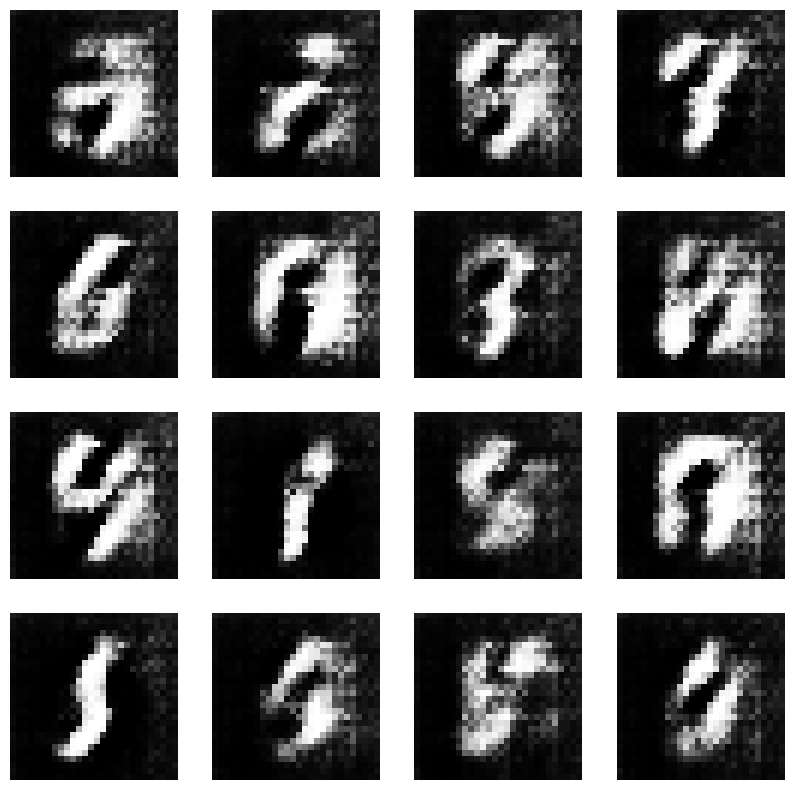

Época:  10


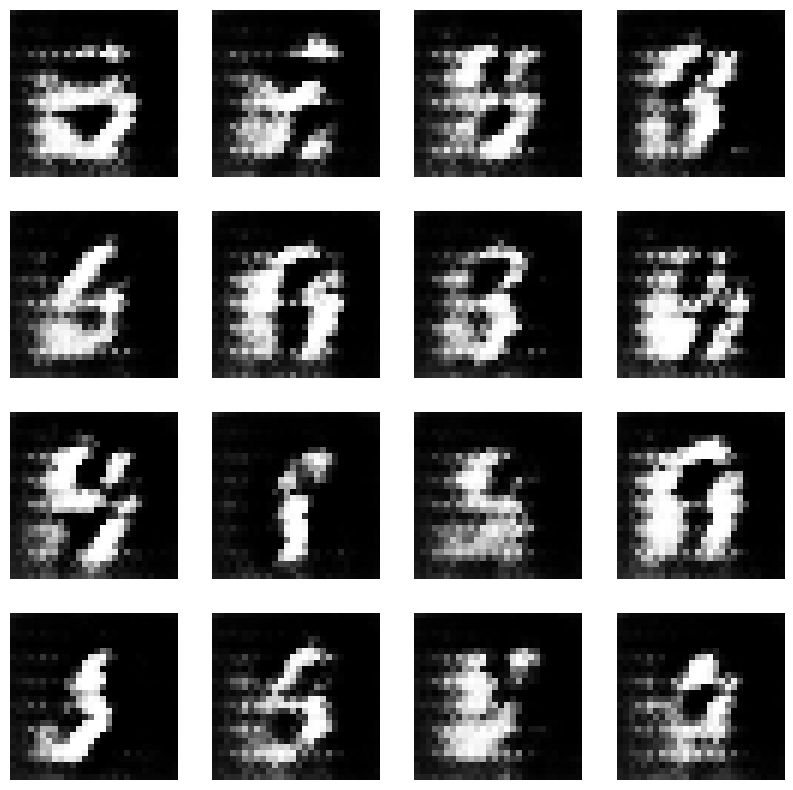

Época:  11


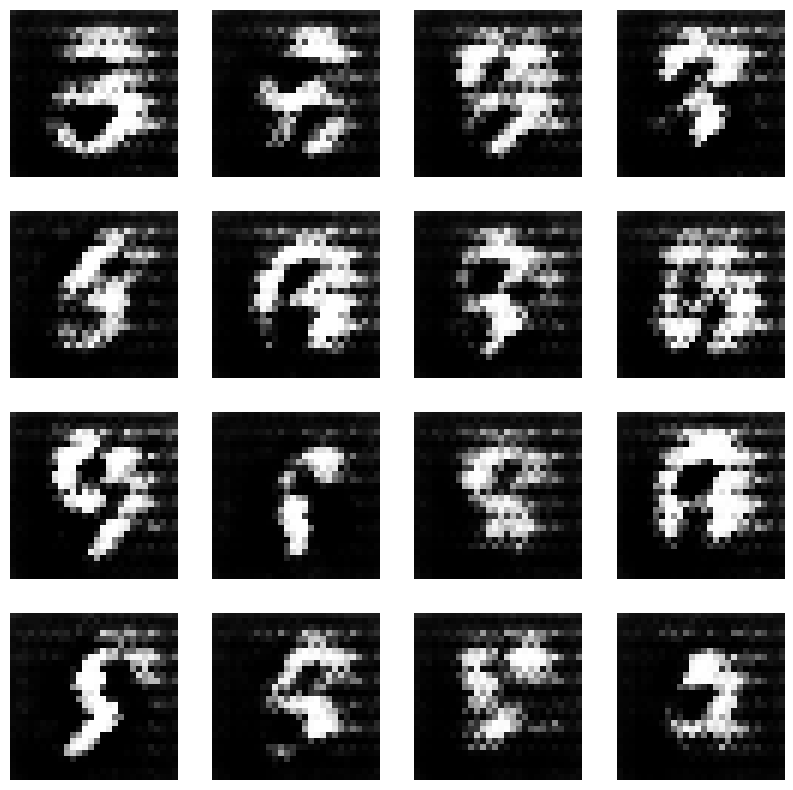

Época:  12


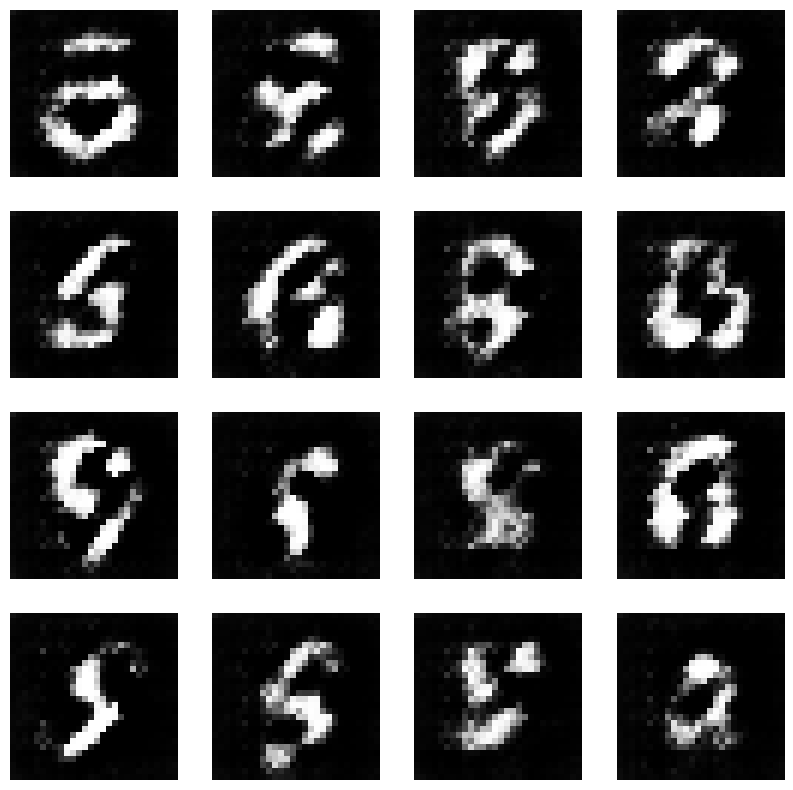

Época:  13


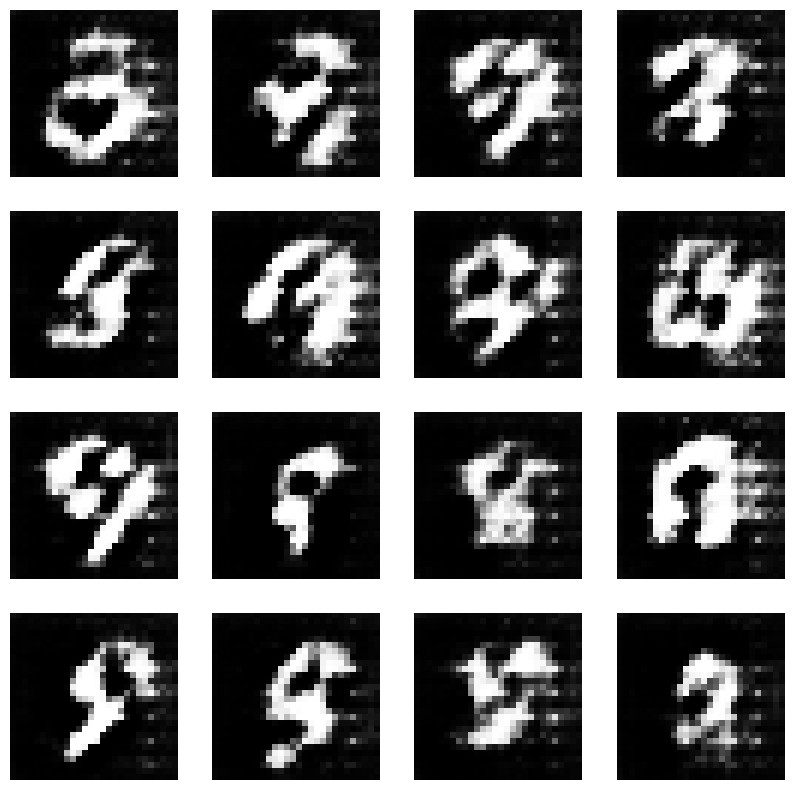

Época:  14


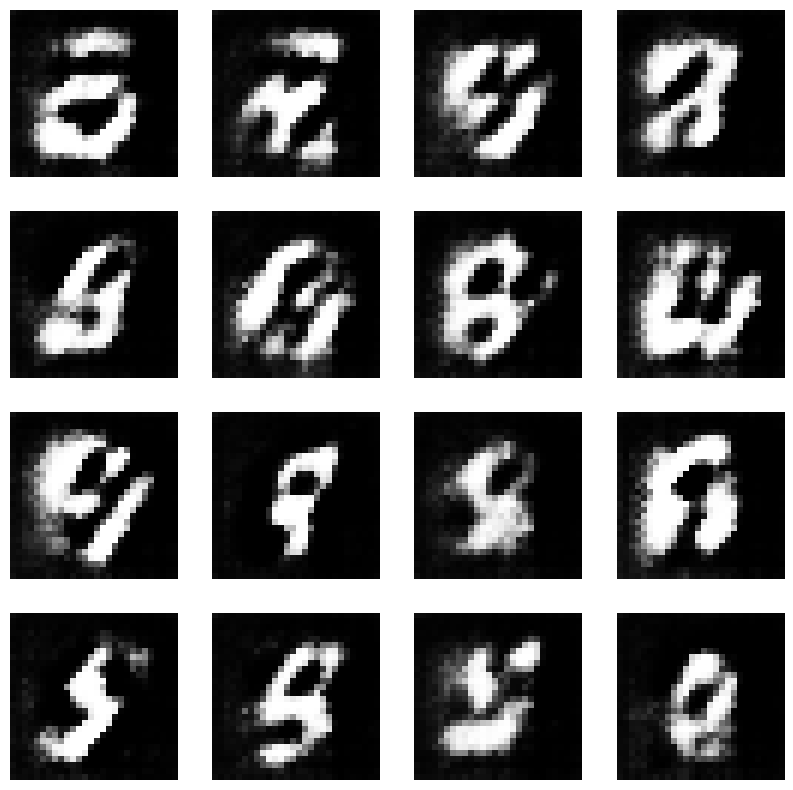

Época:  15


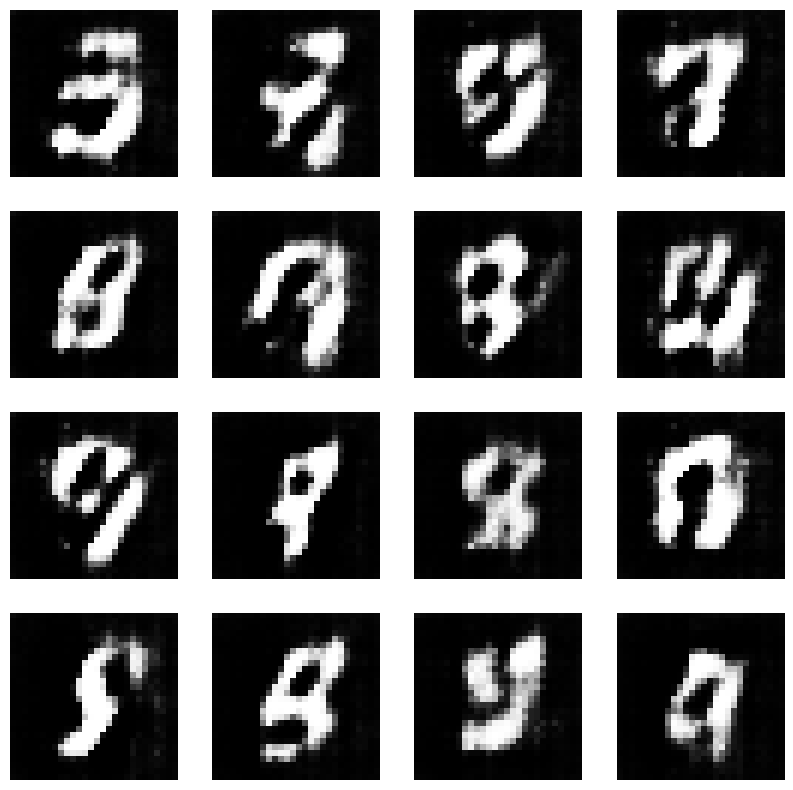

Época:  16


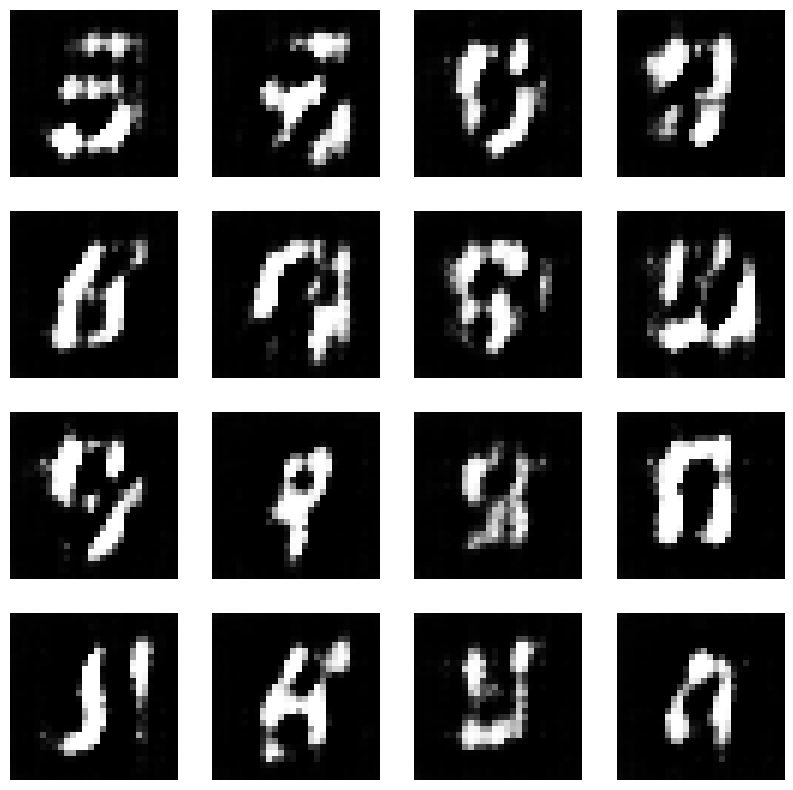

Época:  17


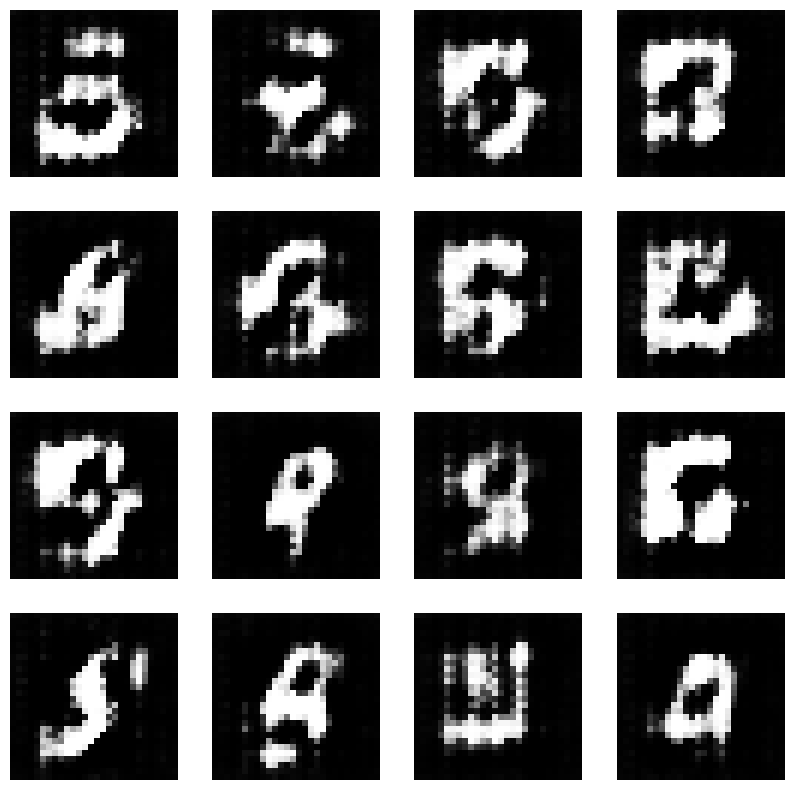

Época:  18


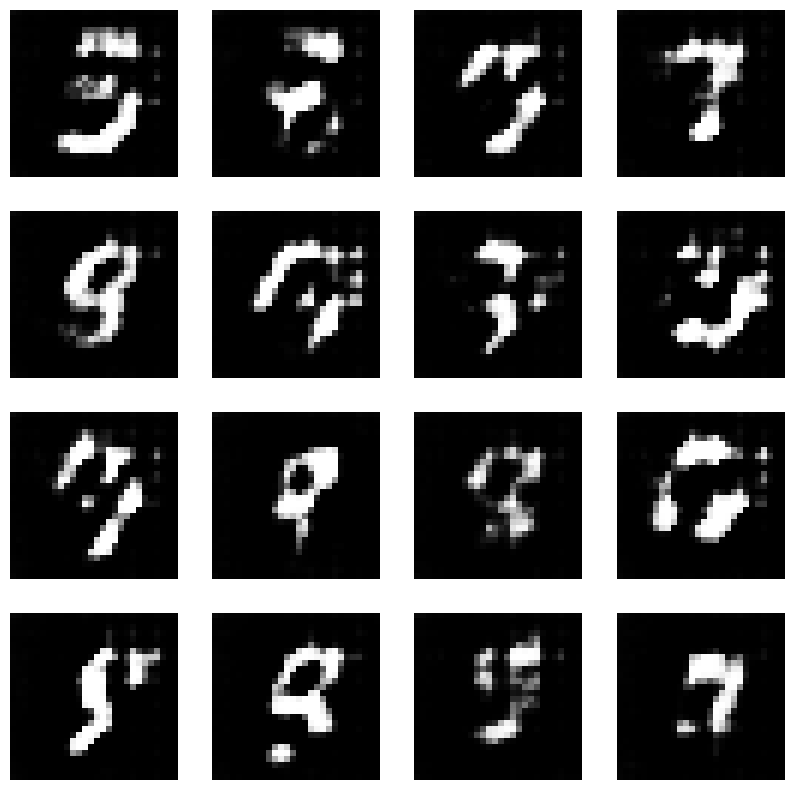

Época:  19


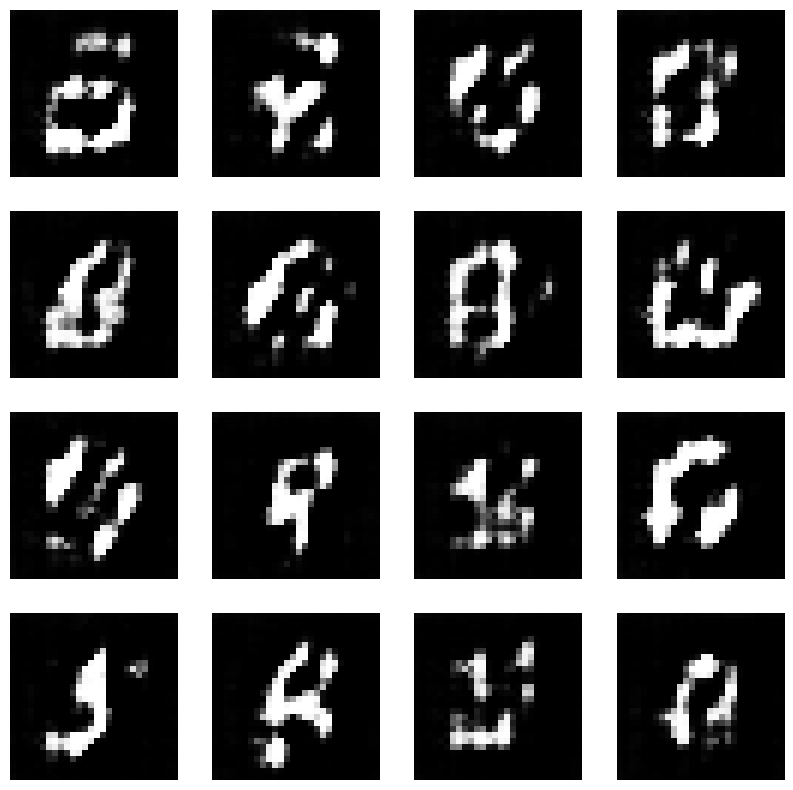

Época:  20


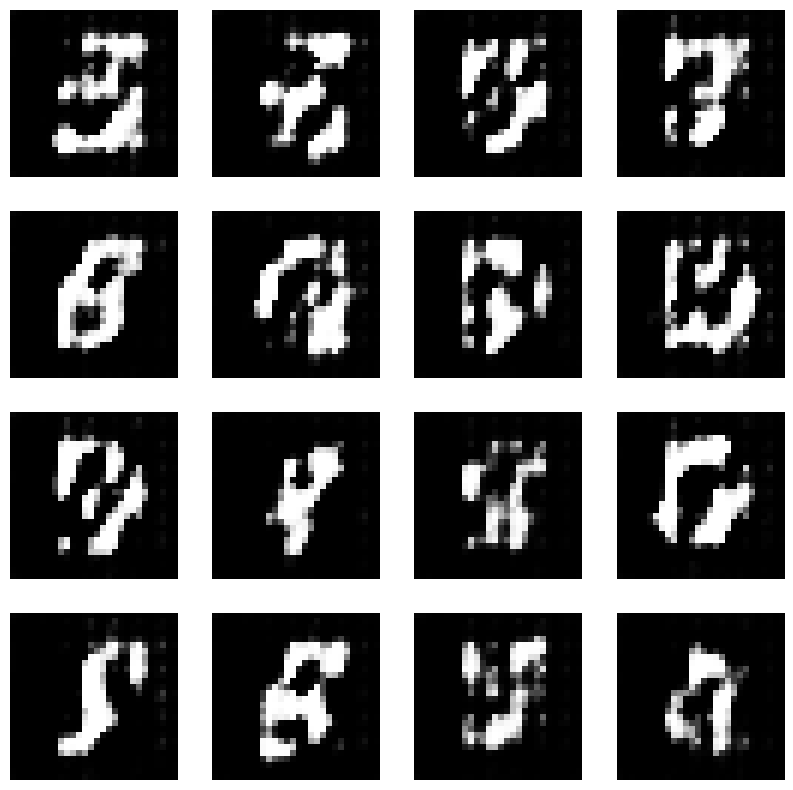

Época:  21


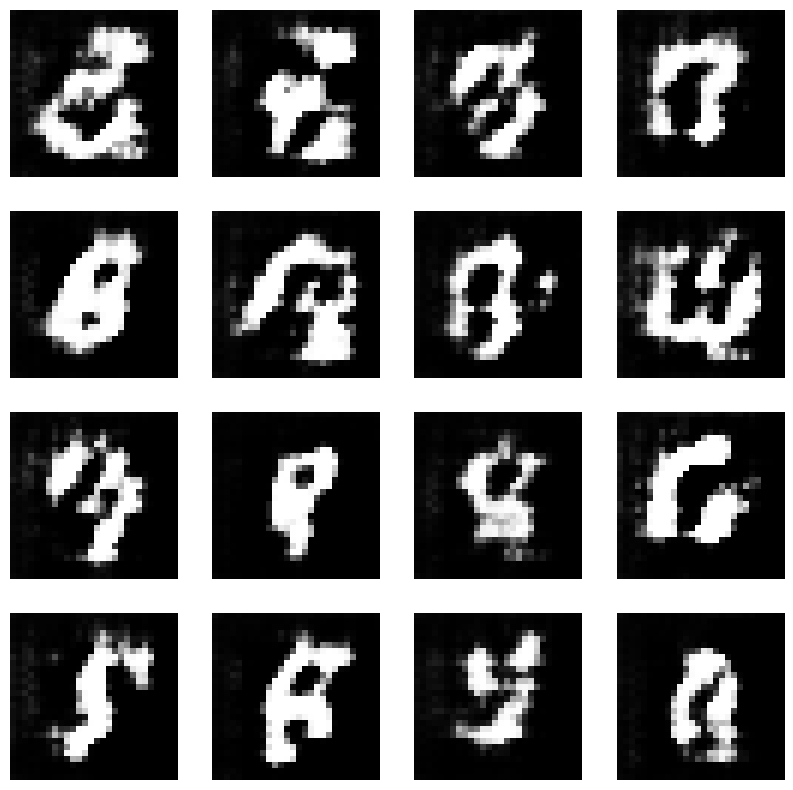

Época:  22


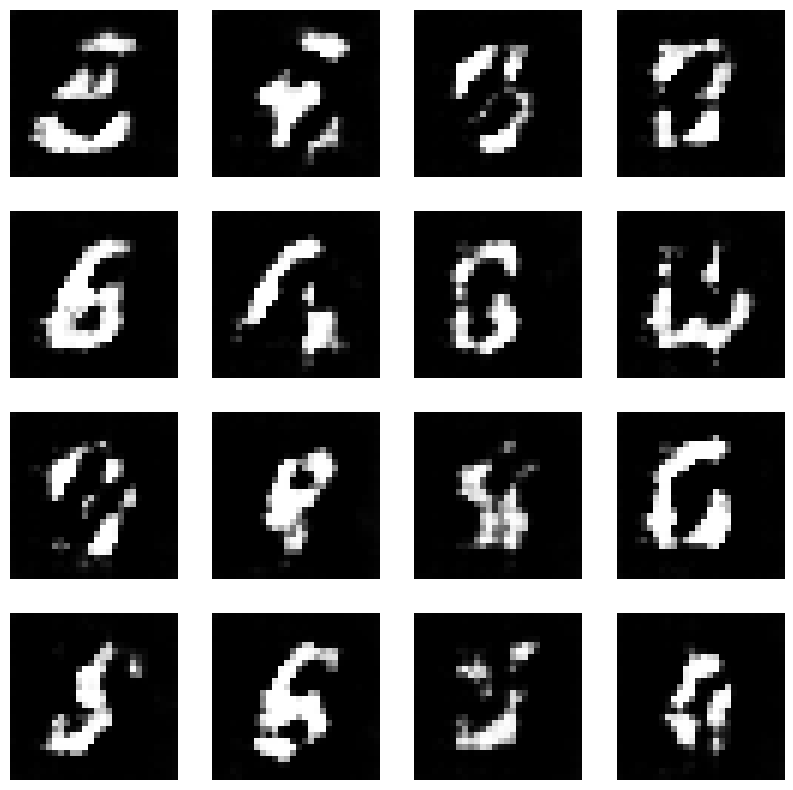

Época:  23


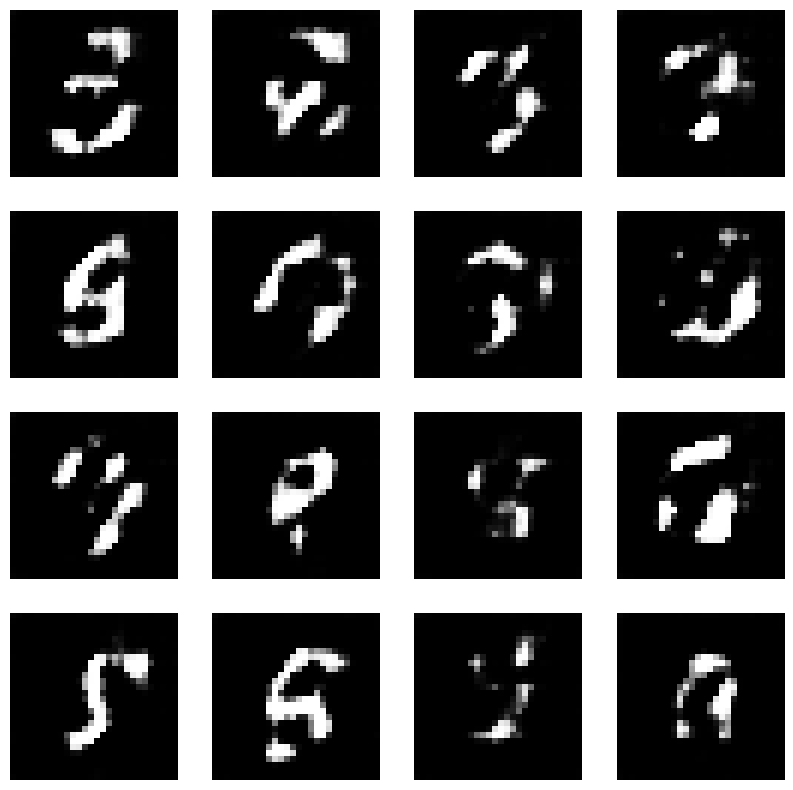

Época:  24


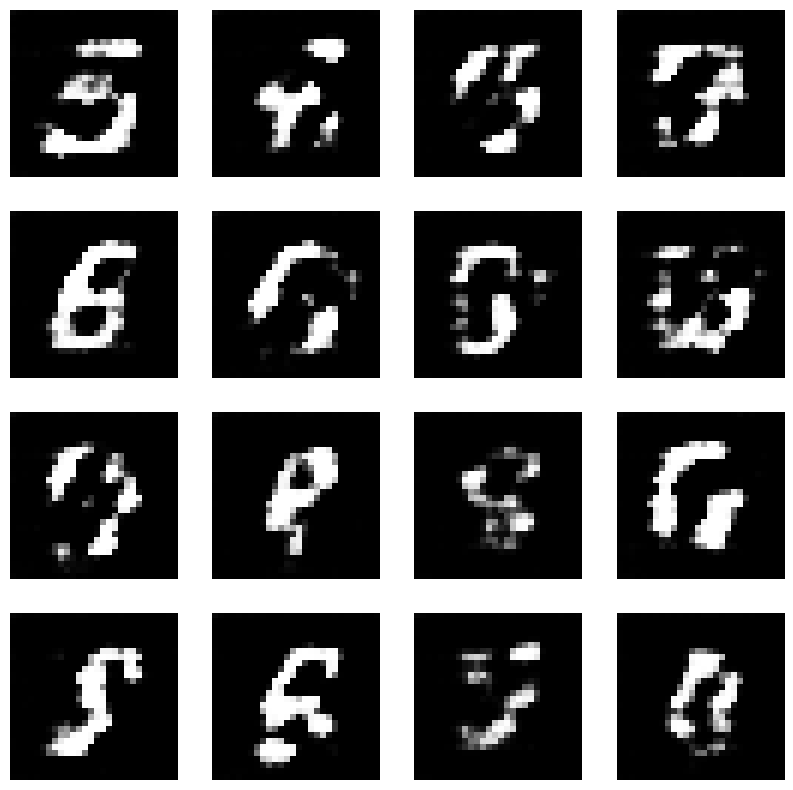

Época:  25


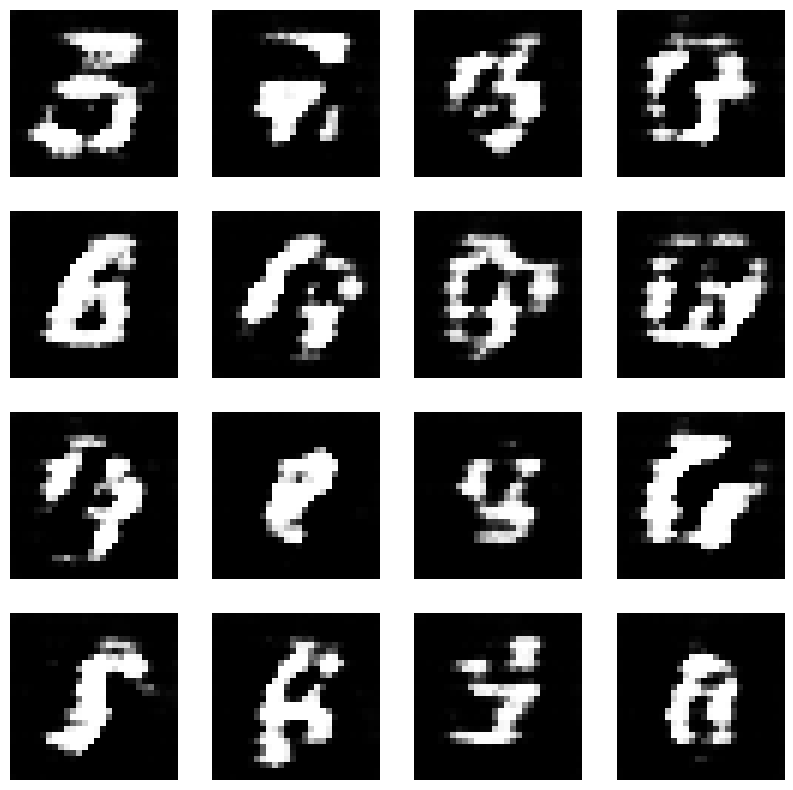

Época:  26


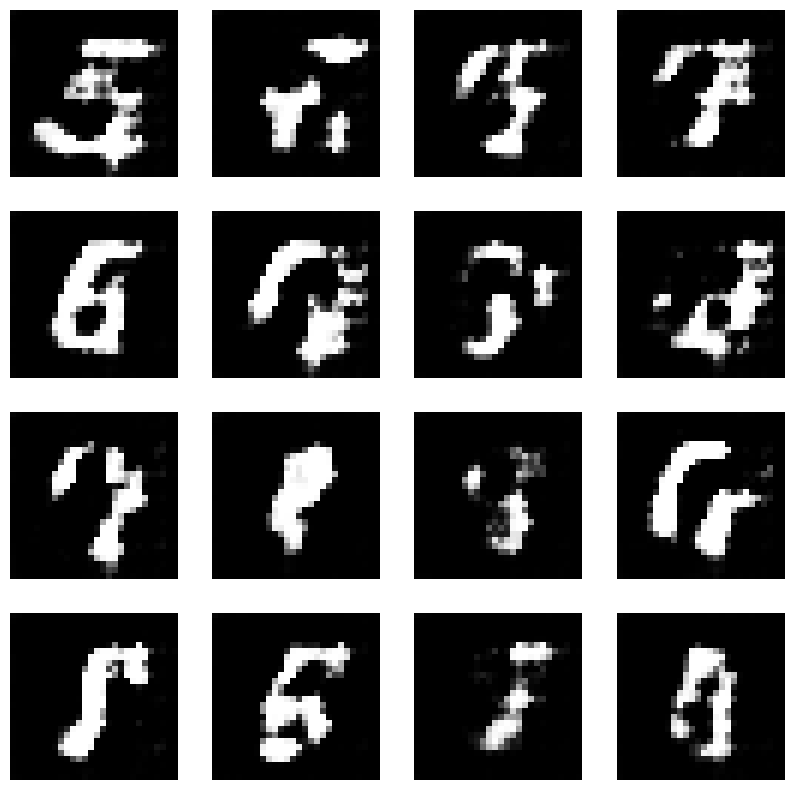

Época:  27


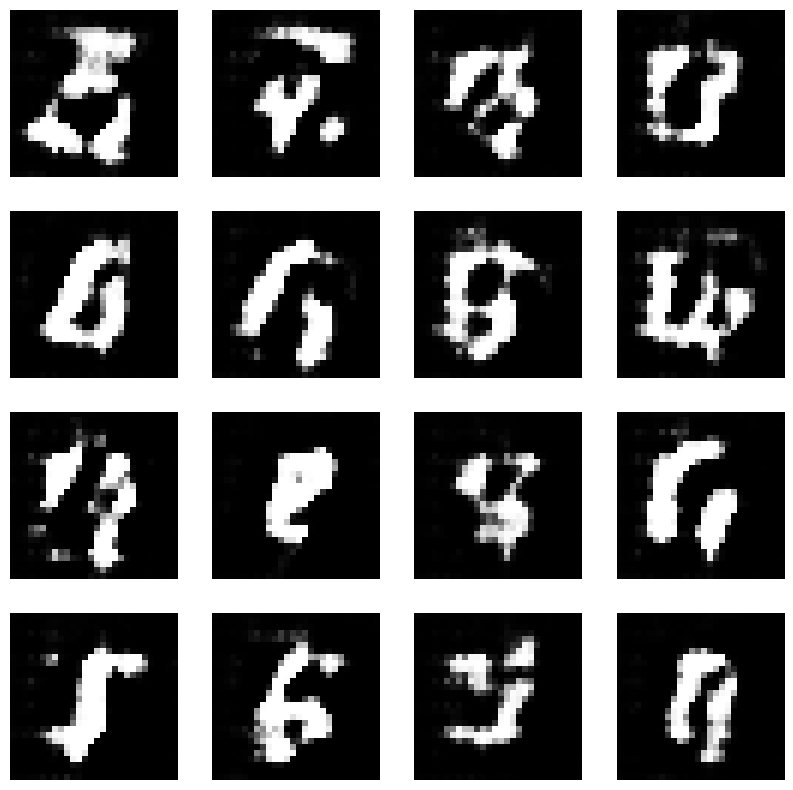

Época:  28


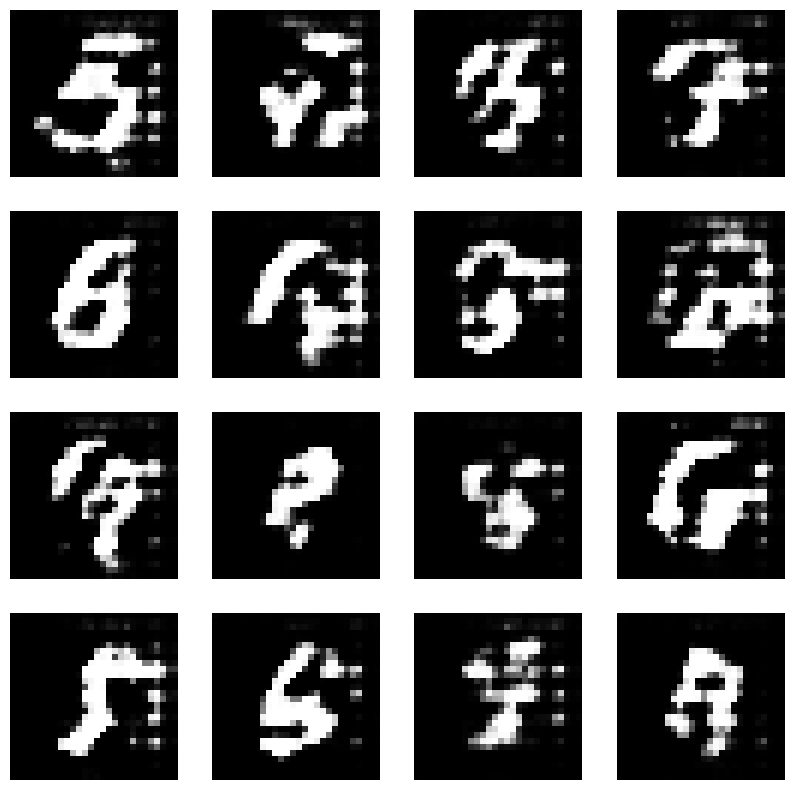

Época:  29


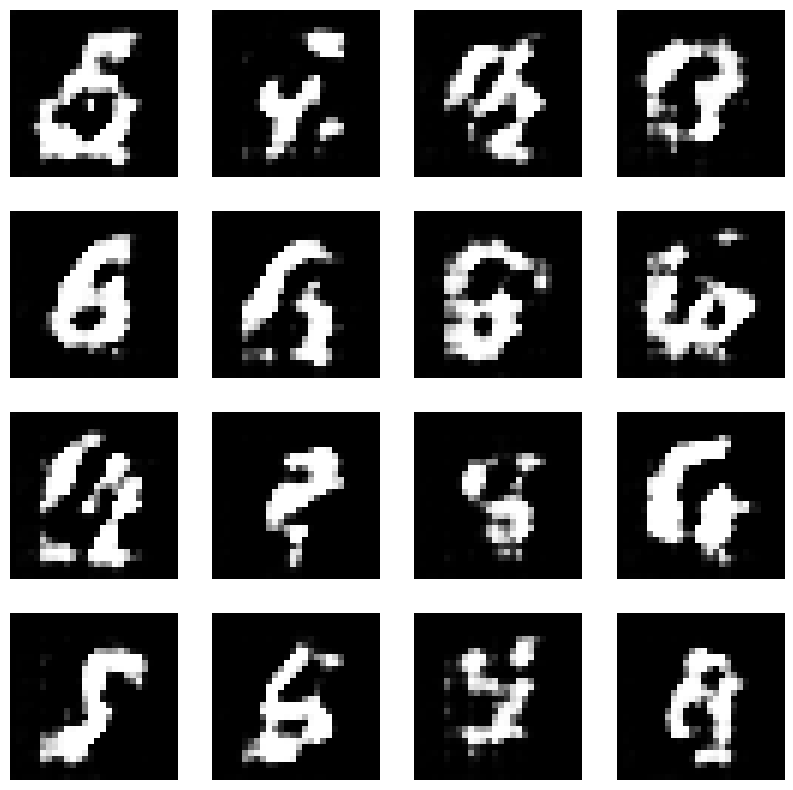

KeyboardInterrupt: 

In [45]:
treina_gan(X_treinamento, epocas, imagens_teste)